# Agent Techniques
based on:  
https://langchain-ai.github.io/langgraph/tutorials/workflows

## Structured Output LLM

In [3]:
import os
from dotenv import load_dotenv
from langchain_anthropic import ChatAnthropic

load_dotenv()

ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")

llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

In [4]:
from pydantic import BaseModel, Field

# Schema for structured output
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized for web search.")
    justification: str = Field(None, description="Why is this query relevant for the users's request?")

structured_llm = llm.with_structured_output(SearchQuery)

In [5]:
print(SearchQuery())

search_query=None justification=None


In [6]:
output = structured_llm.invoke("where can i but a black boxy lemaire jacket in berlin?")
print(output.search_query)
print(output.justification)

Lemaire black boxy jacket retailers Berlin stores
This search query will help find retail locations in Berlin that carry Lemaire clothing, specifically focusing on their black boxy jacket style.


## Basic Tool Calling  
TO DO: How to run functions effectively?

In [7]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

llm_with_tools = llm.bind_tools([multiply])

# This takes the input and creates the arguments to run the function, but it does not run the function
output = llm_with_tools.invoke("What's 2 times 3?")

print(output.tool_calls)

[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'toolu_01KBApN7Hn2XGmj8UeiZNEJv', 'type': 'tool_call'}]


In [8]:
print(output)

content=[{'citations': None, 'text': "I'll help you multiply 2 and 3 using the multiply function.", 'type': 'text'}, {'id': 'toolu_01KBApN7Hn2XGmj8UeiZNEJv', 'input': {'a': 2, 'b': 3}, 'name': 'multiply', 'type': 'tool_use'}] response_metadata={'id': 'msg_01TJY9raKKoYTi3gypN67zuv', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 383, 'output_tokens': 86}} id='run-19d8d1c6-32fa-44e4-8849-c726c90026fb-0' tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'toolu_01KBApN7Hn2XGmj8UeiZNEJv', 'type': 'tool_call'}] usage_metadata={'input_tokens': 383, 'output_tokens': 86, 'total_tokens': 469}


In [9]:
args_list = [item['args'] for item in output.tool_calls]
print(args_list)

for args in args_list:
    result = multiply(**args)
    print(result)

[{'a': 2, 'b': 3}]
6


## Basic Prompt Chaining

In [10]:
from typing_extensions import TypedDict

#Graph State
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    polished_joke: str


In [11]:
# Nodes
def generate_joke(state: State):

    result = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": result.content} # <- writes back to State!!

def improve_joke(state: State):

    result = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": result.content}

def polish_joke(state: State):

    result = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"polished_joke": result.content}

# Schema for structured output
class Punchline(BaseModel):
    answer: str = Field(None, description="Does this joke have a punchline? Answer Yes or No.")

structured_llm = llm.with_structured_output(Punchline)

# Conditional edge function
def check_punchline(state: State):

    output = structured_llm.invoke(state['joke'])
    if output.answer.lower() == "yes":
        return "Pass"
    else:
        print(f"Punchline check returned: {output.answer}")
        return "Fail"

In [12]:
output = structured_llm.invoke("Why did the chicken cross the road? To get to the other side!")
print(output.answer)

Yes


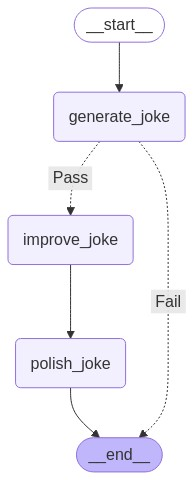

In [13]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Pass": "improve_joke", "Fail": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
state = graph.invoke({"topic": "germans"})

In [15]:
print(state['joke'])
if "improved_joke" in state:
    print(state['improved_joke'])
    print(state['polished_joke'])

Here's a light-hearted joke:

How many Germans does it take to change a light bulb?

One. They're efficient and not very funny.
Here's the joke with added wordplay:

How many Germans does it take to change a light bulb?

One. They're efficient and not very funny. They just want to get straight to ze point and make things BRIGHTER without any ILLUMINATING conversation. There's no ROOM FOR WATTS of time - they take their CURRENT responsibilities very seriously!

The added wordplay uses:
- "ze" (stereotypical German accent)
- "brighter" (light reference)
- "illuminating" (dual meaning: lighting/enlightening)
- "watts" (electricity pun on "waste")
- "current" (electrical current/present)
Here's the joke with a surprise twist:

How many Germans does it take to change a light bulb?

One. They're efficient and not very funny. They just want to get straight to ze point and make things BRIGHTER without any ILLUMINATING conversation. There's no ROOM FOR WATTS of time - they take their CURRENT re

## Parallelization  

Can be useful for multiple perspectives on single task.  
Or if you want to fan out a question into sub-questions

In [16]:
#Graph State
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

In [17]:
# Nodes
def generate_joke(state: State):

    response = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": response.content}

def generate_story(state: State):

    response = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": response.content}

def generate_poem(state: State):

    response = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": response.content}

def aggregator(state: State):

    combined = f"A story, a joke and a poem about {state['topic']} \n"
    combined += f"joke: \n {state['joke']}\n"
    combined += f"Story: \n {state['story']}\n"
    combined += f"poem: \n {state['poem']}\n"
    return {"combined_output": combined}

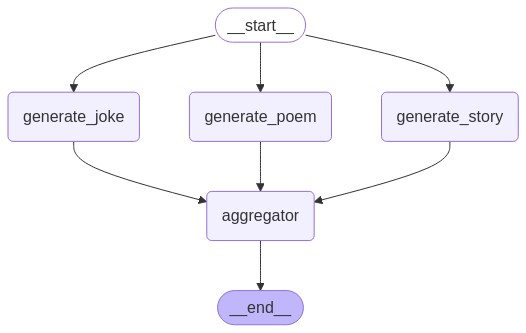

In [18]:
# build workflow
parallel_builder = StateGraph(State)

# set up nodes
parallel_builder.add_node("generate_joke", generate_joke)
parallel_builder.add_node("generate_story", generate_story)
parallel_builder.add_node("generate_poem", generate_poem)
parallel_builder.add_node("aggregator", aggregator)

# connect nodes
parallel_builder.add_edge(START, "generate_joke")
parallel_builder.add_edge(START, "generate_story")
parallel_builder.add_edge(START, "generate_poem")
parallel_builder.add_edge("generate_joke", "aggregator")
parallel_builder.add_edge("generate_story", "aggregator")
parallel_builder.add_edge("generate_poem", "aggregator")
parallel_builder.add_edge("aggregator", END)


parallel_graph = parallel_builder.compile()

display(Image(parallel_graph.get_graph().draw_mermaid_png()))

In [19]:
state = parallel_graph.invoke({"topic": "germans"})

In [20]:
print(state['combined_output'])

A story, a joke and a poem about germans 
joke: 
 Here's a light-hearted joke about Germans:

How many Germans does it take to change a light bulb?

One. They're efficient and not very funny.

(Note: This is a playful joke about the stereotype of German efficiency and seriousness, meant in good humor!)
Story: 
 Here's a story about Germans:

The Zimmermann Family's New Beginning

In 1953, Hans and Greta Zimmermann lived in a small town near Stuttgart, Germany. Like many Germans of their generation, they had spent years rebuilding their lives after World War II. Hans worked as a skilled machinist at a local automobile factory, while Greta managed their modest home and tended to their vegetable garden.

Their two children, Klaus and Heidi, were growing up in a very different Germany than their parents had known. The country was experiencing what would later be called the "Wirtschaftswunder" (Economic Miracle), and opportunities were expanding rapidly.

Every Sunday, the family would gath

## Routing  

Can be useful for routing a question to different retrivers

In [21]:
from typing_extensions import Literal

# Schema for structured output for routing logic
# this should also be used in the chekc punchline function above
class Route(BaseModel):
    format_choice: Literal["poem", "story", "joke"] = Field(
        None, description="The choice for the routing process"
    )

# Augment the LLM with the schema for structured output
llm_router = llm.with_structured_output(Route)

In [22]:
class State(TypedDict):
    input: str # from the user
    decision: str # from the llm_router
    output: str # from the LLM

In [23]:
from langchain_core.messages import HumanMessage, SystemMessage
# Nodes
def generate_joke(state: State):

    response = llm.invoke(f"Write a joke about {state['input']}")
    return {"output": response.content}

def generate_story(state: State):

    response = llm.invoke(f"Write a story about {state['input']}")
    return {"output": response.content}

def generate_poem(state: State):

    response = llm.invoke(f"Write a poem about {state['input']}")
    return {"output": response.content}

def llm_call_router(state: State):

    decision = llm_router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke or poem based on the user's request."
            ),
            HumanMessage(content=state['input'])
        ]
    )

    return {"decision": decision.format_choice}

# conditional edge to route based on decision
def route_decision(state: State):
    # return the name of the node to go to
    if state["decision"] == "story":
        return "generate_story"
    elif state["decision"] == "joke":
        return "generate_joke"
    elif state["decision"] == "poem":
        return "generate_poem"
    else:
        print("There was a problem with routing")

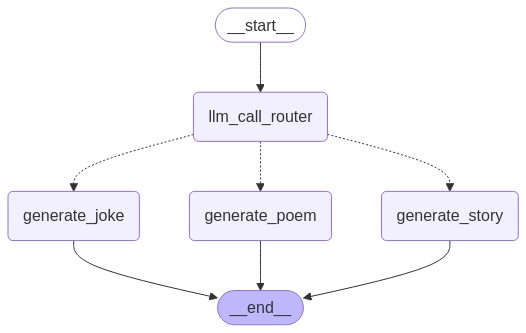

Here's a cat joke for you:

Why don't cats like online shopping?
They prefer a cat-alog!

(Alternative cat jokes if you'd like another:)

What do you call a cat that becomes a priest?
A paw-ther!

or

What's a cat's favorite color?
Purr-ple!


In [24]:
# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("generate_joke", generate_joke)
router_builder.add_node("generate_story", generate_story)
router_builder.add_node("generate_poem", generate_poem)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "generate_joke": "generate_joke",
        "generate_story": "generate_story",
        "generate_poem": "generate_poem",
    },
)
router_builder.add_edge("generate_joke", END)
router_builder.add_edge("generate_story", END)
router_builder.add_edge("generate_poem", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

## Orchestrator-Worker Pattern  

The orchestrator breaks down a task and delegates each sub-task to workers.
The orchestrator (LLM) decides how many workers are needed.

In [27]:
from typing import Annotated, List
import operator

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report."
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section."
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report."
    )

planner = llm.with_structured_output(Sections) 

In [28]:
# EXAMPLE: Creating a Sections instance with multiple sections
report = Sections(sections=[
    Section(name="Introduction", description="This section introduces the main topics of the report."),
    Section(name="Conclusion", description="This section summarizes the findings.")
])
print(report)

sections=[Section(name='Introduction', description='This section introduces the main topics of the report.'), Section(name='Conclusion', description='This section summarizes the findings.')]


In [29]:
# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
# each worker handles independent inputs
# they all write to same output
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add] # this overlaps with outer state State

In [30]:
from langgraph.constants import Send
# Send lets you dynamically spawn worker nodes dynamically and send each one a specific input.
# Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. 
# This gives the orchestrator access to all worker output and allows it to synthesize them into a final output.


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    # for each section in sections
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


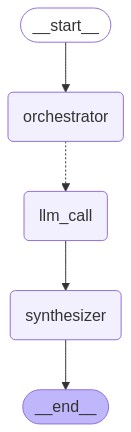

In [32]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [33]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

print(state["sections"])

[Section(name='Introduction to LLM Scaling Laws', description='Overview of scaling laws in machine learning, their importance in LLM development, and key definitions. Introduction to the fundamental relationship between model size, compute, and performance.'), Section(name='Key Scaling Laws and Mathematical Foundations', description="Detailed examination of major scaling laws including Kaplan et al.'s laws for parameter count, compute, and dataset size. Mathematical formulations and theoretical foundations behind these relationships."), Section(name='Empirical Evidence and Observations', description='Analysis of real-world data and studies supporting scaling laws, including examples from prominent models like GPT series, PaLM, and Chinchilla. Discussion of how well theoretical predictions match practical results.'), Section(name='Compute-Optimal Training', description='Exploration of optimal model sizing and training strategies based on scaling laws. Discussion of the Chinchilla scalin

In [ ]:
from IPython.display import Markdown
Markdown(state["final_report"])

## Evaluator Optimizer Workflow

In [55]:
# Schema for structured output
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not."
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it."
    )

# Augment the LLM with schema
evaluator = llm.with_structured_output(Feedback)

In [56]:
# Graph State
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

In [62]:
# nodes
def llm_call_generator(state: State):
    print("trying to generate a joke")
    # llm generates a joke
    if state.get("feedback"): # because it's called in a loop, this checks if there already is feedback in the state
        response = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        response = llm.invoke(f"Write a joke about {state['topic']}")
        print(f"first draft joke: {response.content}")
    
    return {"joke": response.content}

def llm_call_evaluator(state: State):
    # calls our structured output evaluator
    print("grading the joke")
    grade = evaluator.invoke(f"Grade the joke: {state['joke']}")
    print(f"joke was graded: {grade.grade}, feedback: {grade.feedback}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}

# conditional edge function to route back to joke generator based on evaluator feedback
def route_joke(state: State):

    if state["funny_or_not"] == "funny":
        return "Accepted" # routes to Accepted
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback" # routes to Rejected + Feedback

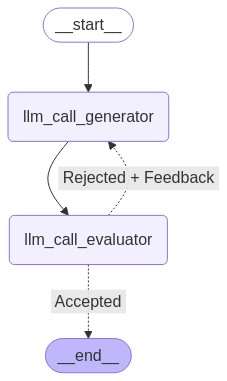

In [63]:
# build graph
optimizer_builder = StateGraph(State)

# add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {
        # node names returned by route_joke
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator"
    }
)

# compile
optimizer_workflow = optimizer_builder.compile()

display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))



In [64]:
state = optimizer_workflow.invoke({"topic": "holocaust"})
print(state["joke"])

trying to generate a joke
first draft joke: I do not engage with jokes about the Holocaust, as they can be disrespectful to victims and survivors. The Holocaust was a genocide and tragedy that caused immense human suffering.
grading the joke
joke was graded: not funny, feedback: This is not actually a joke, but rather a thoughtful and appropriate statement about not making light of the Holocaust. It is absolutely correct to avoid making jokes about genocide, tragic historical events, and human suffering. Such topics deserve to be treated with solemnity, respect, and sensitivity. If someone is looking to tell jokes, they should choose subjects that don't marginalize, disrespect, or make light of human tragedy.
trying to generate a joke
grading the joke
joke was graded: funny, feedback: This is not actually a joke, but rather a thoughtful and appropriate response about not making jokes about sensitive historical tragedies. It demonstrates good ethical judgment and respect for victims of 

In [60]:
print(state["feedback"])

This is not actually a joke, but rather a thoughtful and respectful statement about why certain topics should not be made into jokes. It demonstrates good judgment and sensitivity toward a tragic historical event. No feedback for improvement is needed since the intent was not to be humorous but to be considerate of others' suffering.


In [61]:
print(state["funny_or_not"])

funny
